In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, configure_plot_style, AIBM_COLORS

configure_plot_style()

## Read the data

In [3]:
!ls *.csv

owid_literacy.csv		wef_primary_enrolment.csv
wef_earned_income.csv		wef_primary_enrolment_table.csv
wef_earned_income_table.csv	wef_professional_and_technical_workers.csv
wef_economic_participation.csv	wef_secondary_enrolment.csv
wef_educational_attainment.csv	wef_secondary_enrolment_table.csv
wef_labour_participation.csv	wef_tertiary_enrolment.csv
wef_legislators.csv		wef_tertiary_enrolment_table.csv
wef_legislators_table.csv	wef_wage_equality.csv
wef_literacy_rate.csv		wef_wage_equality_table.csv
wef_literacy_rate_table.csv


In [4]:
xlabel = 'Professional and technical workers percent'

In [5]:

import os
from extract_pdf_data import read_pdfs

filename = "wef_professional_and_technical_workers.csv"
if not os.path.exists(filename):
    df = read_pdfs('professional and technical')
    df.to_csv(filename, index=False)

In [6]:
from utils import read_wef_file

df = read_wef_file(filename)
df.head()

,country,page_number,score,rank,diff,left,right
code,,,,,,,
ALB,Albania,83,1.000,1.0,11.66,44.17,55.83
DZA,Algeria,85,0.916,83.0,-4.40,47.80,52.20
AGO,Angola,87,0.420,129.0,-40.86,29.57,70.43
ARG,Argentina,89,1.000,1.0,7.24,46.38,53.62
ARM,Armenia,91,1.000,1.0,17.86,41.07,58.93


In [7]:
df['rank'].value_counts(dropna=False).head()

rank
1.0      70
NaN       6
129.0     1
83.0      1
138.0     1
Name: count, dtype: int64

In [8]:
df['score'].describe()

count    140.000000
mean       0.830979
std        0.233133
min        0.217000
25%        0.661250
50%        0.996000
75%        1.000000
max        1.000000
Name: score, dtype: float64

In [9]:
dinged = df['score'] < 1
dinged.sum()

np.int64(70)

Here is the distribution of their scores.

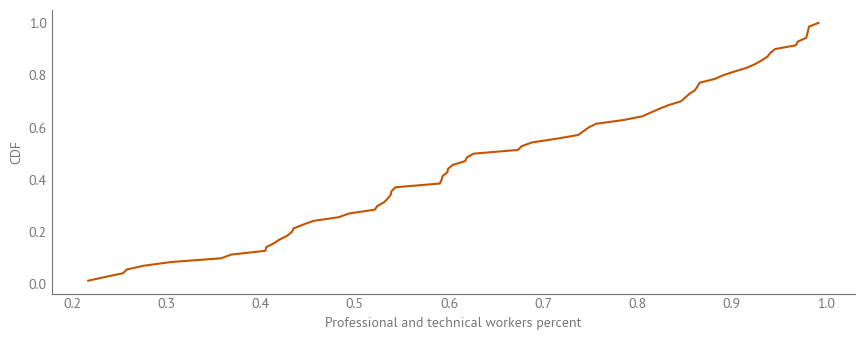

In [10]:
from empiricaldist import Cdf

cdf_score = Cdf.from_seq(df.loc[dinged, 'score'])
cdf_score.plot()
decorate(xlabel=xlabel, ylabel='CDF')

Here is the distribution of differences (female minus male in percentage points) for all countries with valid data.

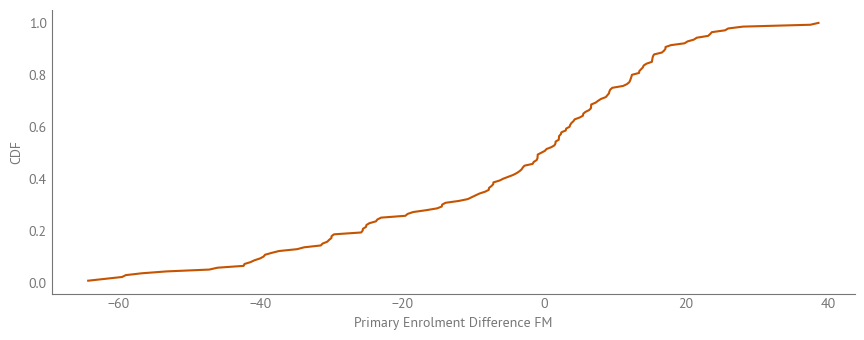

In [11]:
cdf_difference_fm = Cdf.from_seq(df['diff'])
cdf_difference_fm.plot()
decorate(xlabel='Primary Enrolment Difference FM', ylabel='CDF')

In [12]:
subset = df[dinged]
subset.sort_values("diff", ascending=False)

,country,page_number,score,rank,diff,left,right
code,,,,,,,
GBR,United Kingdom,357,0.992,71.0,-0.41,49.79,50.21
LUX,Luxembourg,243,0.982,72.0,-0.92,49.54,50.46
NLD,Netherlands,273,0.981,73.0,-0.94,49.53,50.47
MEX,Mexico,257,0.981,74.0,-0.96,49.52,50.48
COL,Colombia,145,0.979,75.0,-1.08,49.46,50.54
...,...,...,...,...,...,...,...
TGO,Togo,345,0.276,136.0,-56.73,21.63,78.37
MLI,Mali,251,0.258,137.0,-59.00,20.50,79.50
BGD,Bangladesh,101,0.254,138.0,-59.52,20.24,79.76


## Revised scores

The scores are based on ratios, not differences, so let's compute those.

In [13]:
df['ratio'] = df['left'] / df['right']
df['ratio'].describe()

count    140.000000
mean       0.732695
std        0.197398
min        0.217285
25%        0.598785
50%        0.763980
75%        0.892061
max        0.998401
Name: ratio, dtype: float64

Looks like the ratio IS the score.

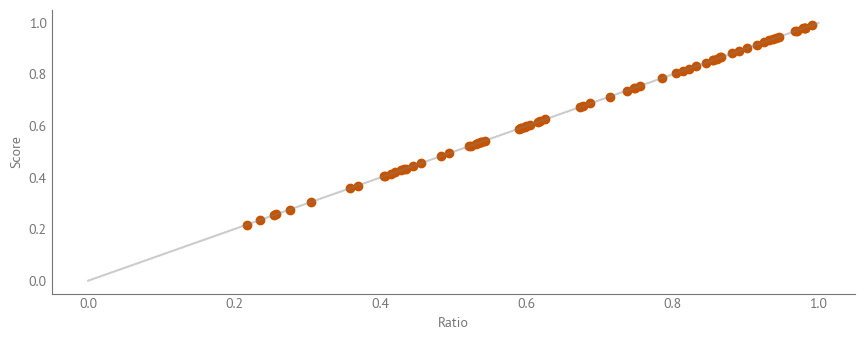

In [14]:
subset = df[dinged]
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(subset['ratio'], subset['score'])
decorate(xlabel='Ratio', ylabel='Score')

So here are the revised, symmetric scores.

In [15]:
df['revised_score'] = df['ratio']
df['revised_score'].describe()

count    140.000000
mean       0.732695
std        0.197398
min        0.217285
25%        0.598785
50%        0.763980
75%        0.892061
max        0.998401
Name: revised_score, dtype: float64

Here's the distribution of revised scores.

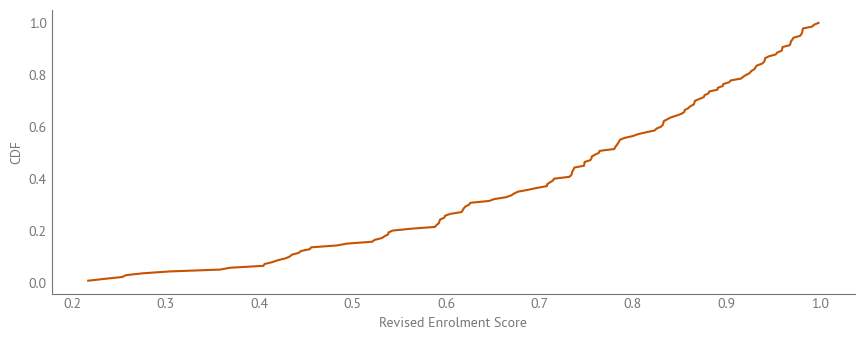

In [16]:
cdf_score = Cdf.from_seq(df['revised_score'])
cdf_score.plot()
decorate(xlabel='Revised Enrolment Score', ylabel='CDF')

Here's the distribution of revised scores, compare to the original.

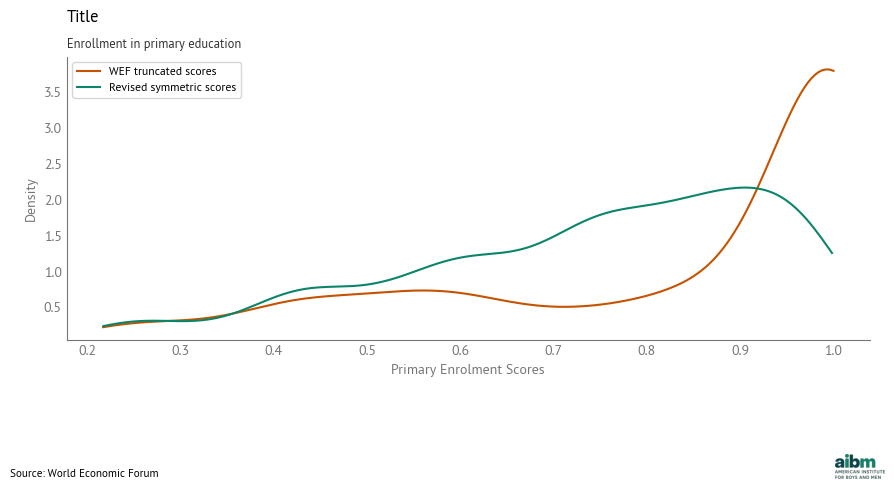

In [17]:
from utils import plot_score_distributions, add_title

plot_score_distributions(df, xlabel='Primary Enrolment Scores')
add_title("Title",
          "Enrollment in primary education")

In [18]:
revised = df[~dinged].dropna(subset=['ratio']).sort_values('revised_score')
revised.shape

(70, 9)

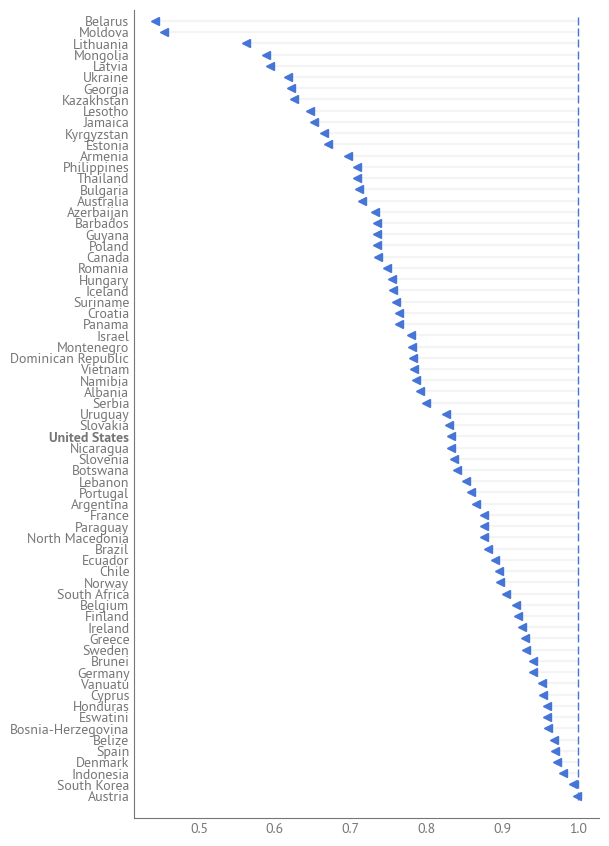

In [19]:
from utils import plot_revised_scores

plot_revised_scores(revised)

## Export the results

In [20]:
from utils import make_rank_table

table = make_rank_table(df)
table.to_csv("wef_professionals_table.csv")
table.shape

(146, 6)

In [21]:
table['score'].describe()

count    140.000000
mean       0.830979
std        0.233133
min        0.217000
25%        0.661250
50%        0.996000
75%        1.000000
max        1.000000
Name: score, dtype: float64

In [22]:
from utils import make_weight_table

make_weight_table(table, 'professional')

original             revised          
                   std   inv std       std   inv std
professional  0.233133  0.042894  0.197398  0.050659

## OECD countries

In [23]:
from utils import oecd_codes

df_oecd = df.loc[oecd_codes].sort_values(by='revised_score')

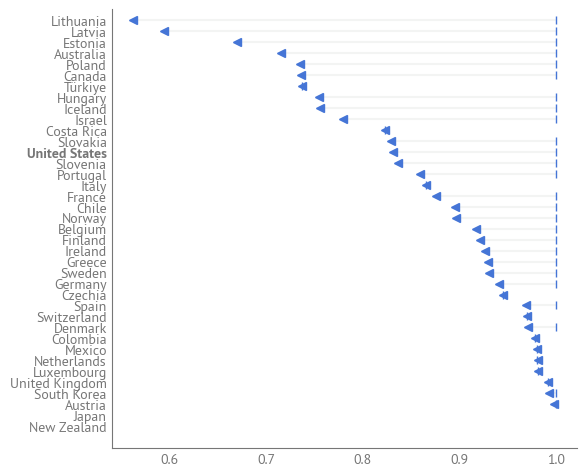

In [24]:
plot_revised_scores(df_oecd)

In [25]:
df.query("country == 'Ireland'")

,country,page_number,score,rank,diff,left,right,ratio,revised_score,revised_rank
code,,,,,,,,,,
IRL,Ireland,211,1.0,1.0,3.83,48.09,51.91,0.926411,0.926411,27.0
